<a href="https://colab.research.google.com/github/sre-glitch/IPL-Analysis/blob/main/IPL_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name:** IPL Analysis Project
## Done By Kolasani Sreya Tulasi

# **Problem Statement:**
The aim of the project is to analyze the data of the Indian Premier League (IPL) to gain insights into the game using Power BI or Tableau


Data Collection: Use the provided IPL datasets.

Data Cleaning and Preparation:
Use Power BI or Tableau to handle missing values and ensure data consistency.

Data Analysis and Visualization:
Create visual representations of the following:
Highest and lowest scorers in the IPL.
Bowlers with the most wickets and those with zero wickets.
Stats of the top 5 bowlers.
Top fielders based on catches and run-outs.
Number of tosses won by each team and match winners after winning the toss.
Most successful IPL teams.
Most sixes and fours by individuals and teams.
Decisions made after winning the toss, both overall and team-wise.
Number of matches hosted by different cities and identify the lucky stadium for the top team.

Insights Generation: Use Power BI/Tableau features to draw meaningful insights and conclusions.

In [2]:
!pip install -q openpyxl
!pip install -q xlrd
!pip install -q pandas

import pandas as pd
import numpy as np
import os
from datetime import datetime
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

print("pandas", pd.__version__)


pandas 2.2.2


In [3]:
from google.colab import files
uploaded = files.upload()

print("Uploaded files:", list(uploaded.keys()))

Saving deliveries.xlsx to deliveries.xlsx
Saving matches (1).xlsx to matches (1).xlsx
Uploaded files: ['deliveries.xlsx', 'matches (1).xlsx']


In [4]:
matches_path = 'matches (1).xlsx'
deliveries_path = 'deliveries.xlsx'

matches = pd.read_excel(matches_path)
deliveries = pd.read_excel(deliveries_path)

print("matches shape:", matches.shape)
print("deliveries shape:", deliveries.shape)
matches.head(2)

matches shape: (636, 18)
deliveries shape: (150460, 21)


,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


In [5]:
m = matches.copy()
d = deliveries.copy()

# Standardize column names to lowercase and strip spaces
m.columns = [c.strip() for c in m.columns]
d.columns = [c.strip() for c in d.columns]

# Convert date column to datetime (common column name: date)
# Try several likely names
for col in ['date', 'Date', 'match_date']:
    if col in m.columns:
        m['date'] = pd.to_datetime(m[col], errors='coerce')
        break

# Team name cleaning map
team_map = {
    'Delhi Daredevils':'Delhi Capitals', 'Dehli Daredevils':'Delhi Capitals',
    'Kings XI Punjab':'Punjab Kings', 'KXIP':'Punjab Kings',
    'Rising Pune Supergiant':'Rising Pune Supergiants', 'Pune Warriors':'Pune Warriors',
    'Delhi Capitals':'Delhi Capitals', 'Sunrisers Hyderabad':'Sunrisers Hyderabad'
}
# Apply map to matches (team1, team2, winner, toss_winner, etc.)
team_cols = [c for c in m.columns if 'team' in c.lower() or 'winner' in c.lower() or c.lower() in ['team1','team2','winner','toss_winner']]
for c in team_cols:
    if c in m.columns:
        m[c] = m[c].replace(team_map).astype('object')

# Standardize team names in deliveries (batting_team, bowling_team)
for c in ['batting_team','bowling_team','player_dismissed','dismissal_kind','fielder']:
    if c in d.columns:
        d[c] = d[c].astype('object')
for c in ['batting_team','bowling_team']:
    if c in d.columns:
        d[c] = d[c].replace(team_map)

# Print some distinct team names
print("Distinct teams in matches:", sorted(m['team1'].dropna().unique().tolist()))
print("Distinct batting teams in deliveries:", sorted(d['batting_team'].dropna().unique().tolist()))

Distinct teams in matches: ['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Gujarat Lions', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Mumbai Indians', 'Pune Warriors', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Sunrisers Hyderabad']
Distinct batting teams in deliveries: ['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Gujarat Lions', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Mumbai Indians', 'Pune Warriors', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Sunrisers Hyderabad']


In [6]:
# Check missing percentages
def missing_report(df, name):
    miss = df.isna().sum()/len(df)*100
    miss = miss[miss>0].sort_values(ascending=False)
    print(f"--- Missing in {name} ---")
    print(miss.head(20))
    print()

missing_report(m, 'matches')
missing_report(d, 'deliveries')

# Drop empty helper columns if present
for col in ['umpire3','dl_applied','player_of_match','result_margin','result','method']:
    if col in m.columns and m[col].isna().all():
        m.drop(columns=[col], inplace=True)

# If any date rows are NaT, warn
if 'date' in m.columns and m['date'].isna().any():
    print(f"Warning: {m['date'].isna().sum()} matches have invalid dates. Consider manual fix.")

# For deliveries: drop rows lacking innings or runs info (if any)
critical_cols = ['inning','over','ball','batsman','bowling_team','batting_team']
for c in critical_cols:
    if c in d.columns:
        d = d[~d[c].isna()]

print("After basic cleaning shapes:", m.shape, d.shape)

--- Missing in matches ---
umpire3            100.000000
city                 1.100629
winner               0.471698
player_of_match      0.471698
umpire1              0.157233
umpire2              0.157233
dtype: float64

--- Missing in deliveries ---
fielder             96.431610
player_dismissed    95.056493
dismissal_kind      95.056493
dtype: float64

After basic cleaning shapes: (636, 17) (150460, 21)


In [7]:
# Add season to matches
if 'season' not in m.columns:
    if 'date' in m.columns:
        m['season'] = m['date'].dt.year
    else:
        # fallback: if a season column exists under a different name
        if 'Season' in m.columns:
            m['season'] = m['Season']

# In deliveries, total_runs commonly present; otherwise compute
if 'total_runs' not in d.columns:
    # many datasets have 'batsman_runs' + 'extra_runs'
    if 'batsman_runs' in d.columns and 'extra_runs' in d.columns:
        d['total_runs'] = d['batsman_runs'] + d['extra_runs']

# Create wicket flag
if 'player_dismissed' in d.columns:
    # Include run outs as wickets
    d['is_wicket'] = d['player_dismissed'].notna()

# Boundaries
if 'batsman_runs' in d.columns:
    d['is_four'] = d['batsman_runs'] == 4
    d['is_six'] = d['batsman_runs'] == 6

# Ensure integers where expected
for col in ['inning','over','ball','batsman_runs','total_runs','extra_runs']:
    if col in d.columns:
        d[col] = pd.to_numeric(d[col], errors='coerce').fillna(0).astype(int)

print("Derived columns added. deliveries sample:")
d[['inning','over','ball','batsman','bowler','batsman_runs','total_runs','is_four','is_six','player_dismissed']].head()

Derived columns added. deliveries sample:


,inning,over,ball,batsman,bowler,batsman_runs,total_runs,is_four,is_six,player_dismissed
0,1,1,1,DA Warner,TS Mills,0,0,False,False,NaN
1,1,1,2,DA Warner,TS Mills,0,0,False,False,NaN
2,1,1,3,DA Warner,TS Mills,4,4,True,False,NaN
3,1,1,4,DA Warner,TS Mills,0,0,False,False,NaN
4,1,1,5,DA Warner,TS Mills,0,2,False,False,NaN


In [8]:
runs_by_player = d.groupby('batsman', dropna=True)['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'total_runs'})
runs_by_player = runs_by_player.sort_values('total_runs', ascending=False)
runs_by_player.head(10)

# Lowest scorers (non-zero appearances).
balls_by_player = d.groupby('batsman').size().rename('balls').reset_index()
player_stats = runs_by_player.merge(balls_by_player, on='batsman', how='left')
lowest = player_stats[player_stats['balls']>=5].sort_values('total_runs').head(20)

print("Top scorers:")
print(runs_by_player.head(10).to_string(index=False))
print("\nLowest scorers (>=5 balls):")
print(lowest.head(10).to_string(index=False))

# Save for Tableau
runs_by_player.to_csv('player_total_runs.csv', index=False)
player_stats.to_csv('player_runs_and_balls.csv', index=False)

Top scorers:
       batsman  total_runs
      SK Raina        4548
       V Kohli        4423
     RG Sharma        4207
     G Gambhir        4132
     DA Warner        4014
    RV Uthappa        3778
      CH Gayle        3651
      S Dhawan        3561
      MS Dhoni        3560
AB de Villiers        3486

Lowest scorers (>=5 balls):
          batsman  total_runs  balls
          S Ladda           0     10
         ND Doshi           0     13
     Shoaib Ahmed           1      6
Mohammad Ashraful           2     12
      RS Gavaskar           2      8
            H Das           2      5
    Shoaib Akhtar           2      8
          A Singh           2     10
  D Kalyankrishna           3      8
       BAW Mendis           3      6


In [9]:
# Identify wicket rows
wicket_kinds = ['bowled','caught','lbw','stumped','caught and bowled','hit wicket']

if 'dismissal_kind' in d.columns and 'bowler' in d.columns:
    d['wicket_by_bowler'] = d['dismissal_kind'].isin(wicket_kinds)
    wickets = d[d['wicket_by_bowler']].groupby('bowler').size().reset_index(name='wickets').sort_values('wickets', ascending=False)
else:
    wickets = pd.DataFrame(columns=['bowler','wickets'])

# Count bowlers with zero wickets but who bowled at least some balls
balls_bowled = d.groupby('bowler').size().rename('balls').reset_index()
bowler_stats = balls_bowled.merge(wickets, on='bowler', how='left').fillna({'wickets':0})
bowler_stats['wickets'] = bowler_stats['wickets'].astype(int)
bowler_stats['balls'] = bowler_stats['balls'].astype(int)

most_wickets = bowler_stats.sort_values('wickets', ascending=False).head(20)
zero_wicket_bowlers = bowler_stats[(bowler_stats['wickets']==0) & (bowler_stats['balls']>=6)].sort_values('balls',ascending=False)

print("Top wicket takers:")
print(most_wickets.head(10).to_string(index=False))
print("\nBowlers with zero wickets (but >=6 balls bowled):")
print(zero_wicket_bowlers.head(10).to_string(index=False))

# Save
bowler_stats.to_csv('bowler_stats.csv', index=False)
wickets.to_csv('bowler_wickets.csv', index=False)

Top wicket takers:
         bowler  balls  wickets
     SL Malinga   2694      154
       A Mishra   2703      134
Harbhajan Singh   2989      127
      PP Chawla   2594      126
       DJ Bravo   2110      122
        B Kumar   2054      111
        A Nehra   1974      106
  R Vinay Kumar   2161      103
         Z Khan   2276      102
       R Ashwin   2359      100

Bowlers with zero wickets (but >=6 balls bowled):
      bowler  balls  wickets
      K Goel     67        0
  K Upadhyay     56        0
    AC Voges     56        0
   KAJ Roach     52        0
    M Manhas     42        0
  AUK Pathan     41        0
     M Vijay     37        0
SR Tendulkar     37        0
   SA Abbott     32        0
 VS Yeligati     32        0


Available files: ['.config', 'bowler_stats.csv', 'matches (1).xlsx', 'player_total_runs.csv', 'bowler_wickets.csv', 'deliveries.xlsx', 'player_runs_and_balls.csv', 'sample_data']
✅ File loaded successfully!
Columns in dataset: ['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs', 'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs', 'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed', 'dismissal_kind', 'fielder']
   match_id  inning         batting_team                 bowling_team  over  \
0         1       1  Sunrisers Hyderabad  Royal Challengers Bangalore     1   
1         1       1  Sunrisers Hyderabad  Royal Challengers Bangalore     1   
2         1       1  Sunrisers Hyderabad  Royal Challengers Bangalore     1   
3         1       1  Sunrisers Hyderabad  Royal Challengers Bangalore     1   
4         1       1  Sunrisers Hyderabad  Royal Challengers Bangalore     1   

   ball   

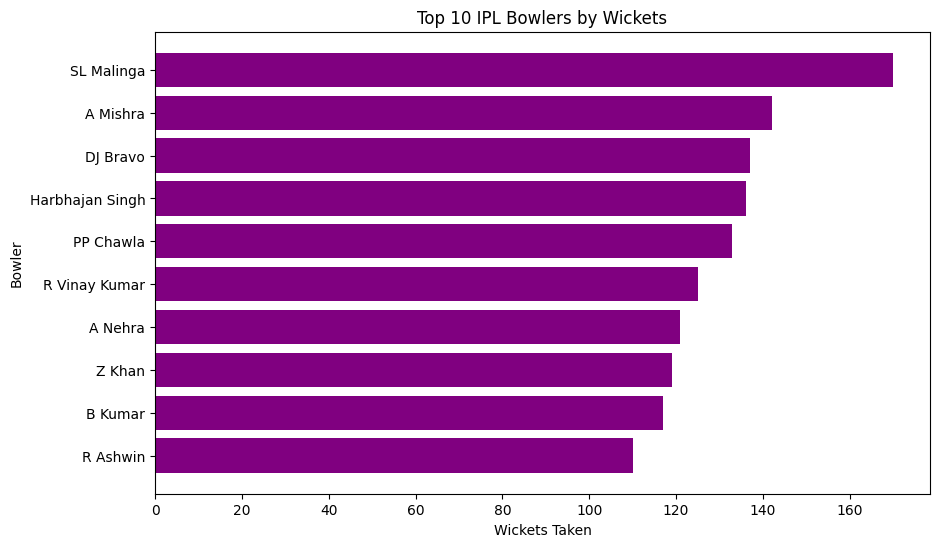

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Check available files
print("Available files:", os.listdir())

# 2. Load deliveries.xlsx
df = pd.read_excel("deliveries.xlsx")
print("File loaded successfully!")
print("Columns in dataset:", df.columns.tolist())
print(df.head())

# 3. Handle wickets (sometimes column names differ)
# Common wicket dismissal columns in IPL dataset
wicket_cols = ["player_dismissed", "dismissal_kind"]

if "player_dismissed" not in df.columns:
    raise KeyError("No 'player_dismissed' column found. Check dataset columns above.")

# 4. Calculate top bowlers by wickets
# Filter rows where a batsman was dismissed
wickets = df[df["player_dismissed"].notnull()]

# Count dismissals per bowler
top_bowlers = wickets.groupby("bowler")["player_dismissed"].count().reset_index()
top_bowlers.columns = ["Bowler", "Wickets"]

# Sort and take top 10
top_bowlers = top_bowlers.sort_values(by="Wickets", ascending=False).head(10)

print("\n Top 10 Bowlers by Wickets:")
print(top_bowlers)

# 5. Plot
plt.figure(figsize=(10,6))
plt.barh(top_bowlers["Bowler"], top_bowlers["Wickets"], color="purple")
plt.xlabel("Wickets Taken")
plt.ylabel("Bowler")
plt.title("Top 10 IPL Bowlers by Wickets")
plt.gca().invert_yaxis()  # Highest on top
plt.show()


In [11]:
# catches: count dismissal_kind == 'caught' and fielder present
if 'dismissal_kind' in d.columns and 'fielder' in d.columns:
    catches = d[d['dismissal_kind']=='caught'].groupby('fielder').size().reset_index(name='catches').sort_values('catches', ascending=False)
else:
    catches = pd.DataFrame(columns=['fielder','catches'])

# run-outs: dismissal_kind contains 'run out' and fielder sometimes given
runouts = d[d['dismissal_kind'].str.contains('run out', na=False)].groupby('fielder').size().reset_index(name='run_outs').sort_values('run_outs', ascending=False)

# Merge
fielders = catches.merge(runouts, on='fielder', how='outer').fillna(0)
fielders['total_fielding_effects'] = fielders['catches'] + fielders['run_outs']
fielders = fielders.sort_values('total_fielding_effects', ascending=False)
print("Top fielders:")
print(fielders.head(15).to_string(index=False))

fielders.to_csv('fielder_stats.csv', index=False)

Top fielders:
       fielder  catches  run_outs  total_fielding_effects
    KD Karthik     88.0      13.0                   101.0
      MS Dhoni     76.0      20.0                    96.0
      SK Raina     83.0      13.0                    96.0
AB de Villiers     81.0      13.0                    94.0
    RV Uthappa     75.0       8.0                    83.0
     RG Sharma     70.0       9.0                    79.0
       V Kohli     60.0      14.0                    74.0
    KA Pollard     64.0       8.0                    72.0
       NV Ojha     65.0       7.0                    72.0
      PA Patel     60.0      10.0                    70.0
      DJ Bravo     52.0      12.0                    64.0
     MK Pandey     47.0      14.0                    61.0
     DA Warner     52.0       8.0                    60.0
     RA Jadeja     40.0      19.0                    59.0
  AC Gilchrist     51.0       8.0                    59.0


In [12]:
# 11 - toss and outcome analysis
# toss winner counts
if 'toss_winner' in m.columns:
    toss_counts = m['toss_winner'].value_counts().rename_axis('team').reset_index(name='toss_wins')
else:
    toss_counts = pd.DataFrame()

# matches where toss winner also match winner
if 'toss_winner' in m.columns and 'winner' in m.columns:
    m['toss_win_and_match_win'] = (m['toss_winner'] == m['winner'])
    toss_win_match_win = m.groupby('toss_winner')['toss_win_and_match_win'].agg(['count','sum']).reset_index().rename(columns={'count':'matches_when_toss_won','sum':'times_won_match_after_toss'})
    toss_win_match_win['win_rate_after_toss'] = toss_win_match_win['times_won_match_after_toss'] / toss_win_match_win['matches_when_toss_won']
else:
    toss_win_match_win = pd.DataFrame()

print("Toss counts head:")
print(toss_counts.head(10).to_string(index=False))
print("\nToss-winner -> match-win after toss (team-wise):")
print(toss_win_match_win.sort_values('win_rate_after_toss', ascending=False).head(15).to_string(index=False))

toss_counts.to_csv('toss_counts.csv', index=False)
toss_win_match_win.to_csv('toss_win_match_win.csv', index=False)


Toss counts head:
                       team  toss_wins
             Mumbai Indians         85
      Kolkata Knight Riders         78
             Delhi Capitals         72
Royal Challengers Bangalore         70
               Punjab Kings         68
        Chennai Super Kings         66
           Rajasthan Royals         63
            Deccan Chargers         43
        Sunrisers Hyderabad         35
              Pune Warriors         20

Toss-winner -> match-win after toss (team-wise):
                toss_winner  matches_when_toss_won  times_won_match_after_toss  win_rate_after_toss
              Gujarat Lions                     15                          10             0.666667
        Chennai Super Kings                     66                          42             0.636364
    Rising Pune Supergiants                     13                           8             0.615385
             Mumbai Indians                     85                          48             0.564706
   

In [13]:
# 12 - team performance: most successful teams
if 'winner' in m.columns:
    team_wins = m['winner'].value_counts().rename_axis('team').reset_index(name='match_wins')
else:
    team_wins = pd.DataFrame()

# wins by season
if 'season' in m.columns and 'winner' in m.columns:
    wins_by_season = m.groupby(['season','winner']).size().reset_index(name='wins').sort_values(['season','wins'], ascending=[True,False])
else:
    wins_by_season = pd.DataFrame()

# total matches played by team (team1 or team2)
teams_play_counts = pd.concat([m[['team1','season']].rename(columns={'team1':'team'}), m[['team2','season']].rename(columns={'team2':'team'})])
teams_play_counts = teams_play_counts.groupby('team').size().reset_index(name='matches_played')
team_summary = teams_play_counts.merge(team_wins, on='team', how='left').fillna({'match_wins':0})
team_summary['win_percentage'] = team_summary['match_wins'] / team_summary['matches_played']

print("Most successful teams (by match wins):")
print(team_summary.sort_values('match_wins', ascending=False).to_string(index=False))

team_summary.to_csv('team_summary.csv', index=False)
wins_by_season.to_csv('wins_by_season.csv', index=False)

Most successful teams (by match wins):
                       team  matches_played  match_wins  win_percentage
             Mumbai Indians             157          92        0.585987
        Chennai Super Kings             131          79        0.603053
      Kolkata Knight Riders             148          77        0.520270
Royal Challengers Bangalore             152          73        0.480263
               Punjab Kings             148          70        0.472973
           Rajasthan Royals             118          63        0.533898
             Delhi Capitals             147          62        0.421769
        Sunrisers Hyderabad              76          42        0.552632
            Deccan Chargers              75          29        0.386667
    Rising Pune Supergiants              30          15        0.500000
              Gujarat Lions              30          13        0.433333
              Pune Warriors              46          12        0.260870
       Kochi Tuskers Kera

In [14]:
# 13 - fours and sixes
if 'is_four' in d.columns and 'is_six' in d.columns:
    boundaries_player = d.groupby('batsman').agg(fours=('is_four','sum'), sixes=('is_six','sum')).reset_index()
    boundaries_team = d.groupby('batting_team').agg(team_fours=('is_four','sum'), team_sixes=('is_six','sum')).reset_index()
else:
    boundaries_player = pd.DataFrame()
    boundaries_team = pd.DataFrame()

print("Top boundary hitters (players):")
print(boundaries_player.sort_values('sixes', ascending=False).head(10).to_string(index=False))
print("\nTop boundary teams:")
print(boundaries_team.sort_values('team_sixes', ascending=False).to_string(index=False))

boundaries_player.to_csv('boundaries_by_player.csv', index=False)
boundaries_team.to_csv('boundaries_by_team.csv', index=False)

Top boundary hitters (players):
       batsman  fours  sixes
      CH Gayle    297    266
      SK Raina    402    174
     RG Sharma    354    173
       V Kohli    384    160
     DA Warner    401    160
AB de Villiers    287    158
      MS Dhoni    251    156
     YK Pathan    240    149
    KA Pollard    158    148
  Yuvraj Singh    205    141

Top boundary teams:
               batting_team  team_fours  team_sixes
Royal Challengers Bangalore        1978         935
             Mumbai Indians        2145         876
               Punjab Kings        2083         762
        Chennai Super Kings        1770         742
             Delhi Capitals        1970         686
      Kolkata Knight Riders        1978         659
           Rajasthan Royals        1630         538
            Deccan Chargers         957         400
        Sunrisers Hyderabad         999         364
              Pune Warriors         525         196
    Rising Pune Supergiants         368         157
    

In [15]:
# 14 - toss decision analysis
# Common column is 'toss_decision' or 'toss_decision' variants
decision_col = None
for col in ['toss_decision','toss_decision ' ,'toss_decision.']:
    if col in m.columns:
        decision_col = col
if 'toss_decision' in m.columns:
    decision_col = 'toss_decision'
if decision_col is None:
    # try 'toss_choice' or inspect
    for col in m.columns:
        if 'toss' in col.lower() and 'decision' in col.lower():
            decision_col = col
            break

if decision_col and 'toss_winner' in m.columns:
    toss_decision_overall = m[decision_col].value_counts().rename_axis('decision').reset_index(name='count')
    toss_decision_teamwise = m.groupby(['toss_winner', decision_col]).size().reset_index(name='count').sort_values(['toss_winner','count'], ascending=[True,False])
    print("Toss decision overall:")
    print(toss_decision_overall.to_string(index=False))
    print("\nToss decision team-wise head:")
    print(toss_decision_teamwise.head(20).to_string(index=False))
    toss_decision_overall.to_csv('toss_decision_overall.csv', index=False)
    toss_decision_teamwise.to_csv('toss_decision_teamwise.csv', index=False)
else:
    print("No toss decision column detected in matches dataset. Please check column names:", m.columns.tolist())


Toss decision overall:
decision  count
   field    363
     bat    273

Toss decision team-wise head:
          toss_winner toss_decision  count
  Chennai Super Kings           bat     44
  Chennai Super Kings         field     22
      Deccan Chargers           bat     24
      Deccan Chargers         field     19
       Delhi Capitals         field     46
       Delhi Capitals           bat     26
        Gujarat Lions         field     14
        Gujarat Lions           bat      1
 Kochi Tuskers Kerala         field      5
 Kochi Tuskers Kerala           bat      3
Kolkata Knight Riders         field     48
Kolkata Knight Riders           bat     30
       Mumbai Indians         field     45
       Mumbai Indians           bat     40
        Pune Warriors           bat     11
        Pune Warriors         field      9
         Punjab Kings         field     43
         Punjab Kings           bat     25
     Rajasthan Royals         field     35
     Rajasthan Royals           bat   

In [16]:
# 15 - matches hosted by cities and stadium luckiness
# common columns: city, venue, stadium
city_col = 'city' if 'city' in m.columns else None
venue_col = 'venue' if 'venue' in m.columns else None
if city_col is None:
    for c in ['city','City','venue','Venue','stadium','ground']:
        if c in m.columns:
            city_col = c
            break

if city_col:
    matches_by_city = m[city_col].value_counts().rename_axis('city').reset_index(name='matches_hosted')
    print("Matches hosted by city head:")
    print(matches_by_city.head(20).to_string(index=False))
    matches_by_city.to_csv('matches_by_city.csv', index=False)
else:
    print("No city/venue column found. Columns:", m.columns.tolist())

# Lucky stadium for top team: find where the top team has best win % (with min matches threshold)
# Identify top team by total wins
if 'winner' in m.columns and venue_col in m.columns:
    top_team = team_summary.sort_values('match_wins', ascending=False).iloc[0]['team']
    team_matches_at_venue = m[(m['team1']==top_team) | (m['team2']==top_team)].groupby(venue_col).apply(lambda df: pd.Series({
        'matches': len(df),
        'wins': (df['winner']==top_team).sum()
    })).reset_index().rename(columns={0:'stats'})
    # simpler:
    tm = m[(m['team1']==top_team) | (m['team2']==top_team)]
    venue_stats = tm.groupby(venue_col).agg(matches=('id','count') if 'id' in m.columns else ('date','count'), wins=('winner', lambda s: (s==top_team).sum())).reset_index()
    venue_stats['win_pct'] = venue_stats['wins'] / venue_stats['matches']
    venue_stats = venue_stats[venue_stats['matches']>=3].sort_values('win_pct', ascending=False)  # threshold 3 matches
    print(f"Top team: {top_team}")
    print("Venue win pct for top team (venues with >=3 matches):")
    print(venue_stats.head(10).to_string(index=False))
    venue_stats.to_csv('top_team_venue_stats.csv', index=False)
else:
    print("Cannot compute lucky stadium: check 'winner' and 'venue' columns.")


Matches hosted by city head:
          city  matches_hosted
        Mumbai              85
     Bangalore              66
       Kolkata              61
         Delhi              60
     Hyderabad              49
       Chennai              48
    Chandigarh              46
        Jaipur              33
          Pune              32
        Durban              15
     Centurion              12
     Ahmedabad              12
 Visakhapatnam              11
        Rajkot              10
    Dharamsala               9
  Johannesburg               8
     Cape Town               7
Port Elizabeth               7
        Ranchi               7
     Abu Dhabi               7
Top team: Mumbai Indians
Venue win pct for top team (venues with >=3 matches):
                                              venue  matches  wins  win_pct
                                       Eden Gardens       11     9 0.818182
                              M Chinnaswamy Stadium       10     8 0.800000
             

/tmp/ipython-input-1880988474.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_matches_at_venue = m[(m['team1']==top_team) | (m['team2']==top_team)].groupby(venue_col).apply(lambda df: pd.Series({


In [17]:
top_bowlers.to_csv("top_bowlers.csv", index=False)

print("Exported CSV files successfully!")

from google.colab import files

# Download top bowlers file
files.download("top_bowlers.csv")

Exported CSV files successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>